# Notebook 03 - Drought in the Netherlands with Time Series Modeling

*Martin Vonk - 2022*

This notebooks shows a quick calculation of the SPI, SPEI and SGI for De Bilt, in the Netherlands. The SGI is calculated using a [Pastas](https://github.com/pastas/pastas) time series model since the original time series is too short. The application of time series models for extrapolating groundwater time series is discussed in [Brakkee et al (2022)](https://hess.copernicus.org/articles/26/551/2022/hess-26-551-2022.html).

## Required packages

In [1]:
import datetime
import spei as si  # si for standardized index
import pandas as pd
import pastas as ps

import hydropandas as hpd
import scipy.stats as scs
import matplotlib.pyplot as plt

print(si.show_versions())

Versions
python: 3.10.12
spei: 0.4.0
numpy: 1.26.4
scipy: 1.12.0
matplotlib: 3.8.3
pandas: 2.2.1



/home/martin/.cache/pypoetry/virtualenvs/spei-env--196-leg-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import time series

Time series are imported using the package hydropandas. Enddate is by default yesterday. The head time series is obtained from a Pastas test dataset.

In [2]:
today = datetime.date.today()
yesterday = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
prec = (
    hpd.PrecipitationObs.from_knmi(
        meteo_var="RH", stn=260, startdate="1959-07-01", enddate=yesterday
    )
    .multiply(1e3)
    .squeeze()
)
prec.index = prec.index.normalize()
evap = (
    hpd.EvaporationObs.from_knmi(
        meteo_var="EV24", stn=260, startdate="1959-07-01", enddate=yesterday
    )
    .multiply(1e3)
    .squeeze()
)
evap.index = evap.index.normalize()
head = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/test-datasets/main/vanderspek_bakker_2017/B32C0572_DE-BILT.csv",
    index_col=0,
    parse_dates=True,
    sep=";",
)

## Calculate SPI and SPEI

In [3]:
# Accumulate time series on monthly basis
spi1 = si.spi(prec, timescale=30, dist=scs.gamma, fit_freq="ME")
spei1 = si.spei((prec - evap), timescale=30, dist=scs.fisk, fit_freq="ME")

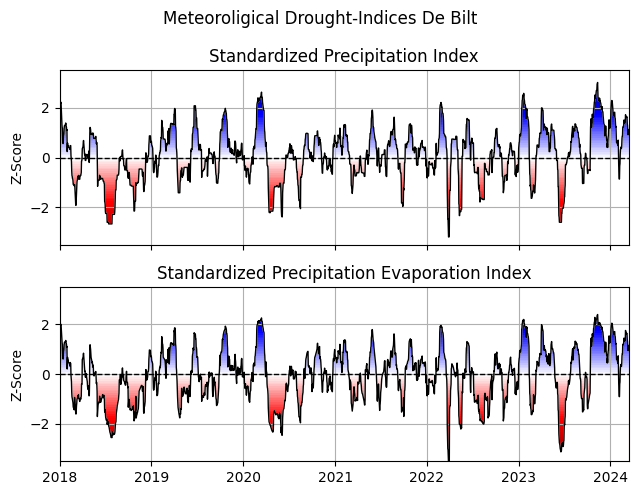

In [4]:
xlim = pd.to_datetime(["2018-01-01", yesterday])

fig, axs = plt.subplots(2, 1, figsize=(6.5, 5), sharex=True)
si.plot.si(spi1, ybound=3.5, ax=axs[0])
si.plot.si(spei1, ybound=3.5, ax=axs[1])
[(x.grid(), x.set_xlim(xlim), x.set_ylabel("Z-Score")) for x in axs]
axs[0].set_title("Standardized Precipitation Index")
axs[1].set_title("Standardized Precipitation Evaporation Index")
fig.suptitle("Meteoroligical Drought-Indices De Bilt")
fig.tight_layout()

## Create time series model and simulate head 

/home/martin/.cache/pypoetry/virtualenvs/spei-env--196-leg-py3.10/lib/python3.10/site-packages/pastas/timeseries_utils.py:90: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  if hasattr(offset, "delta"):
/home/martin/.cache/pypoetry/virtualenvs/spei-env--196-leg-py3.10/lib/python3.10/site-packages/pastas/stressmodels.py:1302: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  if self.prec.series.resample("A").sum().max() < 12:


Fit report Head                         Fit Statistics
nfev    25                     EVP               77.07
nobs    1187                   R2                 0.77
noise   True                   RMSE               0.11
tmin    1970-07-01 00:00:00    AIC            -5977.00
tmax    2020-12-28 00:00:00    BIC            -5936.37
freq    D                      Obj                3.81
warmup  3650 days 00:00:00     ___                    
solver  LeastSquares           Interp.              No

Parameters (8 optimized)
                   optimal     initial   vary   stderr
recharge_A        0.416905    0.443735   True   ±5.62%
recharge_a      125.382206   10.000000   True   ±5.70%
recharge_srmax   38.504461  250.000000   True  ±12.07%
recharge_lp       0.250000    0.250000  False      nan
recharge_ks     213.901407  100.000000   True  ±64.86%
recharge_gamma    4.633510    2.000000   True  ±14.19%
recharge_kv       1.000000    1.000000  False      nan
recharge_simax    2.000000    2.000000 

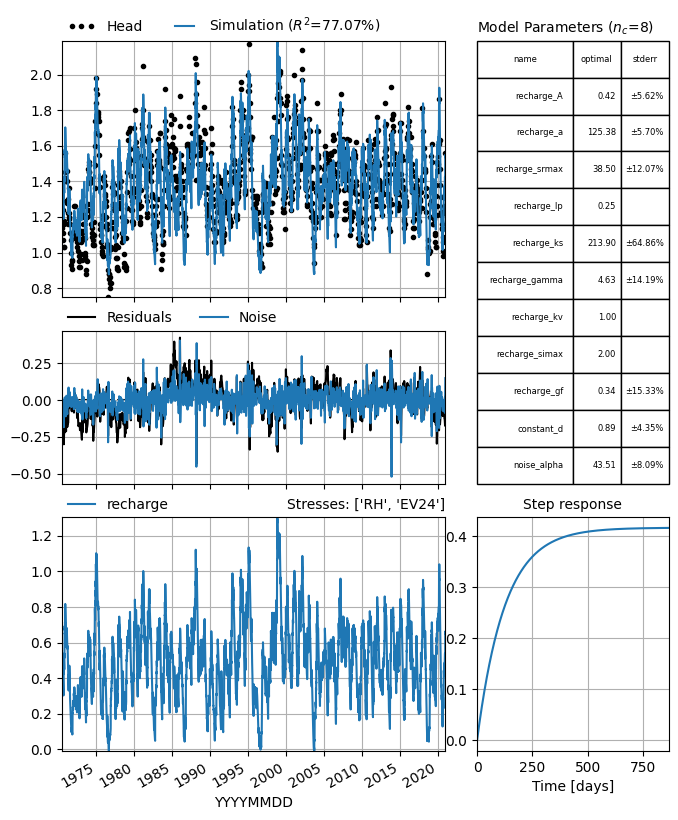

In [5]:
h = head["Head [m] B32C0572_DE-BILT"].rename("Head").dropna()
ml = ps.Model(h)
rm = ps.RechargeModel(
    prec, evap, ps.Exponential(), recharge=ps.rch.FlexModel(gw_uptake=True)
)
ml.add_stressmodel(rm)
ml.solve(tmin="1970-07-01", report=True)
ml.plots.results(figsize=(6.5, 8));

## Calculate SGI based on time series model

In [6]:
gws = ml.simulate(tmin="1990-07-01", tmax=yesterday)
sgi = si.sgi(gws, fit_freq="ME")

INFO: Time Series 'EV24' was extended in the future to 2024-03-13 00:00:00 with the mean value (1.6) of the time series.
INFO:pastas.timeseries:Time Series 'EV24' was extended in the future to 2024-03-13 00:00:00 with the mean value (1.6) of the time series.


## Compare three drought-indices (SPI, SPEI, SGI) in plot

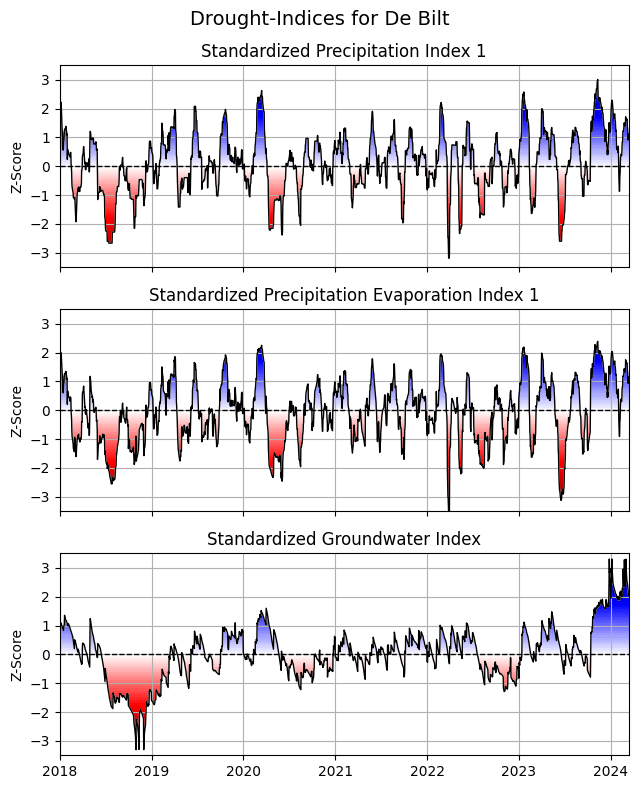

In [7]:
fig, axs = plt.subplot_mosaic(
    [["SPI"], ["SPEI"], ["SGI"]], figsize=(6.5, 8), sharex=True
)
si.plot.si(spi1, ybound=3.5, ax=axs["SPI"])
si.plot.si(spei1, ybound=3.5, ax=axs["SPEI"])
si.plot.si(sgi, ybound=3.5, ax=axs["SGI"])
[(axs[x].grid(), axs[x].set_xlim(xlim), axs[x].set_ylabel("Z-Score")) for x in axs]
axs["SPI"].set_title("Standardized Precipitation Index 1")
axs["SPEI"].set_title("Standardized Precipitation Evaporation Index 1")
axs["SGI"].set_title("Standardized Groundwater Index")
fig.suptitle("Drought-Indices for De Bilt", fontsize=14)
fig.tight_layout()
# fig.savefig('Drought_Index_Bilt.png', dpi=600, bbox_inches='tight')

## Compare SPEI Kernel Density Estimate for one month

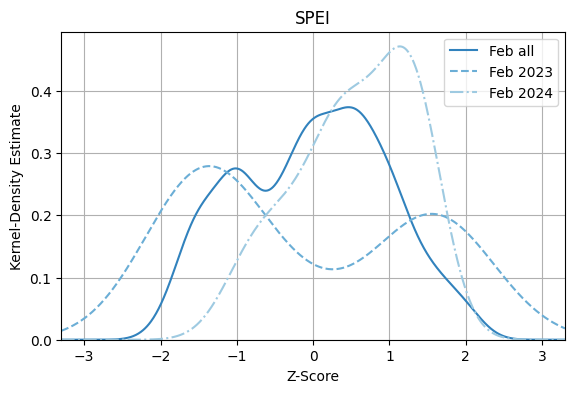

In [8]:
ax = si.plot.monthly_density(
    spei1, years=[today.year - 1, today.year], months=[today.month - 1]
)
ax.set_xlabel("Z-Score")
ax.set_title("SPEI");